# Post-processing Examples

This notebook builds on the results of the previous exercise to perform post-processing useful to:
  * Reduce False Positive changes or changes that are irrelevant for the Use Case under analysis
  * Extract maps of changes and estimate their size 
  * Classify changes respect to different criteria
  
In particular, we will use the Char Piya island Use Case introduced before


In [1]:
!/opt/anaconda/envs/env_better/bin/pip3 install folium shapely tqdm

     |████████████████████████████████| 93 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 6.0 MB/s  eta 0:00:01
     |████████████████████████████████| 61 kB 484 kB/s  eta 0:00:01
     |████████████████████████████████| 125 kB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 6.7 MB/s  eta 0:00:01
     |████████████████████████████████| 133 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 9.7 MB/s eta 0:00:01


In [2]:
import ogr
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import chi2,norm,normaltest
from skimage.filters import threshold_otsu, threshold_yen, threshold_li
from helpers import *

## Overview of the area

In [3]:
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
import numpy as np
import folium
import fiona

pre_data = 'data/backscatterCharpiya20171220.tif'
post_data = 'data/backscatterCharpiya20180910.tif'
vector_fn = 'data/InsideCharpiya.shp'

with fiona.open(vector_fn, 'r') as shapefile:
    shapes = [feature['geometry'] for feature in shapefile]
    
files = [pre_data, post_data]
imgs = list()

m = folium.Map([22.38, 91.4], zoom_start=12)

for i,file in enumerate(files):
    with rasterio.open(file) as src:
        img = src.read(1)
        imgs.append(img)

        folium_img = folium.raster_layers.ImageOverlay(
                name=file,
                image=image_histogram_equalization(img)[0], 
                bounds=[[src.bounds.bottom, src.bounds.left], [src.bounds.top, src.bounds.right]],
                opacity=0.9)
        folium_img.add_to(m)

folium.GeoJson(shapes[0], name='Inside Camp').add_to(m)
folium.LayerControl().add_to(m)
m

### I: Limiting the extension of the area where we are interested in changes

In [4]:
from shapely.geometry import shape

m = folium.Map([22.38, 91.4], zoom_start=14)

masked_images = list()

for i,file in enumerate(files):
    with rasterio.open(file) as src:
        masked_data, masked_transform = rasterio.mask.mask(src, shapes, crop=True) 
        masked_meta = src.meta
        bbox = shape(shapes[0]).bounds
        img = masked_data[0]
        masked_images.append(img)

        folium_img = folium.raster_layers.ImageOverlay(
                name=file,
                image=image_histogram_equalization(img)[0], 
                bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
                opacity=0.9)
        folium_img.add_to(m)

folium.GeoJson(shapes[0], name='Inside Camp').add_to(m)
folium.LayerControl().add_to(m)
m


#### II: Applying a thresholding technique learned earlier

In [5]:
# TODO: Which method to apply?
diff = masked_images[1]-masked_images[0]

empiric_thresholds = [0.1, 0.2, 0.5, 1, 2]
masks = {}

for th in empiric_thresholds:
    mask = np.zeros(diff.shape).astype(np.uint8)
    mask_th = np.logical_or(np.absolute(diff)>th,mask)
    masks['threshold:' + str(th)] = mask_th
    
m = folium.Map([22.38, 91.4], zoom_start=14)

bbox = shape(shapes[0]).bounds
for k,v in masks.items():
    folium_img = folium.raster_layers.ImageOverlay(
                    name=k,
                    image=v,
                    bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
                    opacity=0.9)
    folium_img.add_to(m)

folium.GeoJson(shapes[0], name='Inside Camp').add_to(m)
folium.LayerControl().add_to(m)
m

### III: Some options to deal with False Positives

* Looking at the morphology of the results:
     1. morphological operators
     2. clustering
     3. polygonization


1. Morphological operators

- Morphological image processing is a collection of non-linear operations related to the shape or morphology of features in an image.
- They are especially suited to the processing of binary images, but can also be applied to greyscale images.
- It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation

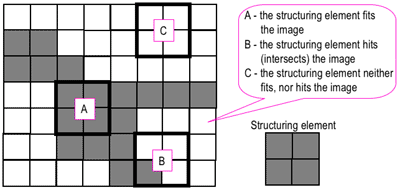

In particular in this example, we will use the Opening and Closing operations to remove noise (opening) and closing small holes inside our forewground objects (changes)

Opening example:

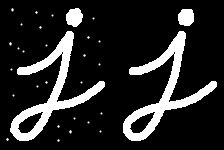

Closing example:

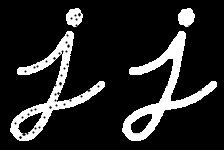

In [6]:
from scipy.ndimage.morphology import binary_closing, binary_opening

iterations = 1
pre_morpho = masks['threshold:0.2']
post_morpho = binary_closing(binary_opening(pre_morpho,iterations=iterations),iterations=iterations)


m = folium.Map([22.38, 91.4], zoom_start=14)

bbox = shape(shapes[0]).bounds
for i,img in enumerate([pre_morpho, post_morpho]):
    folium_img = folium.raster_layers.ImageOverlay(
                    name='pre' if i==0 else 'post',
                    image=img,
                    bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
                    opacity=0.9)
    folium_img.add_to(m)

folium.GeoJson(shapes[0], name='Inside Camp').add_to(m)
folium.LayerControl().add_to(m)
m


2. Clustering

Clustering is the task of dividing a set of data points into a number of groups so that data points in the same groups are more similar to other data points in the same group than those in other groups. 
In simple words, the aim is to segregate groups with similar properties and assign them to clusters.

Unsupervised clustering can allow us to identify changes, as well as to characterise them, e.g.:
 - Assign changes to a specific date
 - Classify changes related to a specific topic: construction of new building, changes due to water channels, changes due to vegetation
 
In particular we will explore the results of a K-means clustering algorithm.

The K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids. It stops creating and optimizing clusters when either:
- The centroids have stabilized — there is no change in their values because the clustering has been successful.
- The defined number of iterations has been achieved.


In [7]:
!/opt/anaconda/envs/env_better/bin/pip3 install sklearn

     |████████████████████████████████| 6.8 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 25.8 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=b35ff79965a086b2ff3ee27f6a9686ee845d87c653208dba1e9ca99d018de74f
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [8]:
from sklearn.cluster import DBSCAN, KMeans

def km_clust(array, n_clusters):
    
    # Create a line array, the lazy way
    X = array.reshape((-1, 1))
    # Define the k-means clustering problem
    k_m = KMeans(n_clusters=n_clusters, n_init=4)
    # Solve the k-means clustering problem
    k_m.fit(X)
    # Get the coordinates of the clusters centres as a 1D array
    values = k_m.cluster_centers_.squeeze()
    # Get the label of each point
    labels = k_m.labels_
    return(values, labels)
'''
def db_clust(array, eps, min_samples):
    
    # Create a line array, the lazy way
    X = array.reshape((-1, 1))
    # Define the k-means clustering problem
    k_m = DBSCAN(eps=eps, min_samples=min_samples)
    # Solve the k-means clustering problem
    k_m.fit(X)
    # Get the coordinates of the clusters centres as a 1D array
    values = k_m.cluster_centers_.squeeze()
    # Get the label of each point
    labels = k_m.labels_
    return(values, labels)
'''
values, labels = km_clust(diff, n_clusters=10)

img_segm = np.choose(labels, values)
img_segm.shape = diff.shape


In [9]:
rgb = np.dstack((masked_images[0],masked_images[1],masked_images[1]))

m = folium.Map([22.38, 91.4], zoom_start=14)
folium_img = folium.raster_layers.ImageOverlay(
                name='Clusters',
                image=img_segm,
                bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
                opacity=0.9,
                colormap=plt.cm.bwr)
folium_img.add_to(m)

folium_acd_img = folium.raster_layers.ImageOverlay(
                name='ACD',
                image=rgb,
                bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
                opacity=0.9,
                show=False)
folium_acd_img.add_to(m)

folium_diff_img = folium.raster_layers.ImageOverlay(
                name='Diff',
                image=diff,
                bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
                opacity=0.9,
                colormap=plt.cm.bwr)
folium_diff_img.add_to(m)

folium.GeoJson(shapes[0], name='Inside Camp').add_to(m)
folium.LayerControl().add_to(m)
m

Questions: 
  - Which clusters represent better the camp construction?
  - Can we extract some statistics of those clusters to perform this same selection in the future?
  - Do you know other possible clustering algorithms that could be applied here? How would you select the number of clusters upfront?
  
Open exercise:
  - Implement a different clustering strategy

In [10]:
labels = np.unique(img_segm)
m = folium.Map([22.38, 91.4], zoom_start=14)

for i,label in enumerate(labels):
    folium_img = folium.raster_layers.ImageOverlay(
                name='Cluster %s' % str(i),
                image=img_segm==label,
                bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
                opacity=0.6)
    folium_img.add_to(m)

folium.LayerControl().add_to(m)
m


Is this a good method to extract the camp size?

In [11]:
m = folium.Map([22.38, 91.4], zoom_start=14)

folium_img = folium.raster_layers.ImageOverlay(
                name='Camp mask',
                image=np.logical_or(img_segm==labels[4],img_segm==labels[5]),
                bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
                opacity=0.6)
folium_img.add_to(m)

folium.LayerControl().add_to(m)
m

3. Polygonization

Another way to limit the effects of False Positives, is by applying prior knowledge about the changes we are interested in.

For example, we may want to group pixels that are close to each other together, so we can consider them as part of the same cluster of changes (as we did above in the clustering part) and then compute the size of the clusters to exclude all changes that are too small to be interesting to us.

In order to do that, we will extract the polygons of changes, compute their extension, and filter out smaller changes.


In [12]:
from rasterio.features import shapes as shapebuilder
import pyproj
from shapely.geometry import shape as shapereader
from copy import deepcopy
from tqdm import tqdm

image = np.array(post_morpho, dtype=np.uint8)
mask=None

results = (
    {'type': 'Feature', 'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v)  in enumerate(
            shapebuilder(image, mask=mask, transform= masked_transform))
        )

geoms = list(results)
big_geoms = list()
AREA_THRESHOLD = 500 #1000 #at least 500sqm

polar = pyproj.Proj(init='epsg:4326')
mercator = pyproj.Proj(init='epsg:3857')

with tqdm(total=len(geoms)) as pbar:
    for geom in geoms:
        if(geom['properties']['raster_val'] != 0):
            s = shapereader(geom['geometry'])
            original_geom = deepcopy(geom)
            projected = project_feature(geom, polar, mercator)
            area = shapereader(projected['geometry']).area
            original_geom['properties']['area'] = area
            if(original_geom['properties']['area'] > AREA_THRESHOLD):
                big_geoms.append(original_geom)
        pbar.update(1)
        
geojson_changes = {
  "type": "FeatureCollection",
  "features": big_geoms
}

/opt/anaconda/envs/env_better/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda/envs/env_better/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/opt/anaconda/envs/env_better/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initial

In [13]:
import json

f = open("data/changes.json", "w")
f.write(json.dumps(geojson_changes))
f.close()

In [14]:
m = folium.Map([22.38, 91.4], zoom_start=14)

folium.GeoJson(geojson_changes, name='Changes').add_to(m)
folium.LayerControl().add_to(m)
m